In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray
import random
import numpy as np
from os import listdir
from os.path import isfile, join
from shapely.geometry import MultiPolygon, Polygon
from sklearn.preprocessing import LabelEncoder 

import sys
sys.path.append("..")
from archive import tree_dataset

# Workflow to generate cutouts of 1 tile from the dataset

In [10]:
# data paths
region = 'Nestor Macias'
root = f'/data/Projects/2024_Invasive_species/Tree_Classification/notebooks/data/reforestree/tiles/{region} RGB/' 
rgb_filenames = [f for f in listdir(root) if isfile(join(root, f))]
rgb_filename = rgb_filenames[4]
classes_path = f'/data/Projects/2024_Invasive_species/Tree_Classification/notebooks/data/reforestree/mapping/final_dataset.csv'

In [11]:
# load classes
annot = pd.read_csv(classes_path)

In [12]:
# Create shapely polygons from coordinates of annotated boxes and convert to geopandas dataframe and extract corresponding classes
# poly_list = []
classes = []
gdf = gpd.GeoDataFrame(columns=['geometry'], crs='epsg:4326', geometry='geometry')
for ind in annot.index:
    if rgb_filename == annot['img_path'][ind]:
        xmin = annot['xmin'][ind]
        xmax = annot['xmax'][ind]
        ymin = annot['ymin'][ind]
        ymax = annot['ymax'][ind]
        poly = (Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]))
        poly_gpd = gpd.GeoDataFrame(crs='epsg:4326', geometry=[poly])
        gdf = pd.concat([gdf.geometry, poly_gpd.geometry], ignore_index=True)
        classes.append(annot['group'][ind])

In [13]:
# Process class labels in to a pandas df with numeric labels
dataclasses = ["other", "banana", "cacao", "citrus", "fruit", "timber"]
classes = pd.DataFrame(classes, columns=['class'])
classes["label"] = classes["class"].apply(dataclasses.index)
classes = classes['label']

In [14]:
#Generate cutouts from tree_dataset module - changes in line 63/64 of module for crs
ds = tree_dataset.TreeDataset([join(root, rgb_filename)], gdf, classes, augment_data=False, max_pixel_size=400, pixel_size=400)

In [15]:
ids, Y, X = ds.get_cutouts()

/data/Projects/2024_Invasive_species/Tree_Classification/notebooks/data/reforestree/tiles/Nestor Macias RGB/Nestor Macias RGB_3_0_9024_4000_13024.png
self.bboxes.crs epsg:4326
rgb.rio.crs EPSG:4326


/data/Projects/2024_Invasive_species/EnvSiamense/lib/python3.10/site-packages/rioxarray/_io.py:1136: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


ida: 8 Y: 2


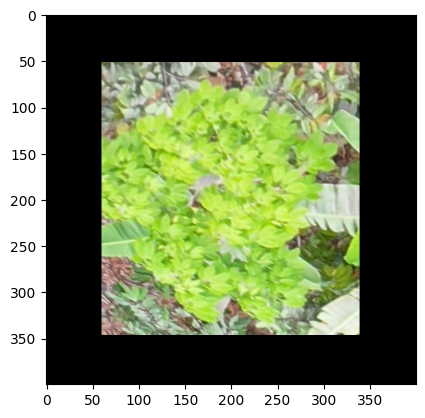

In [16]:
plt.imshow(X[0].astype(int))
print("ida:", ids[0], "Y:", Y[0])
   

# Generate cutouts from all tiles from one site

In [17]:
# The files are already loaded for Nestor Macias for which we will now produce cutouts for all tiles
def tile_cutouts(annot, rgb_filename, dataclasses):
    # Create shapely polygons from coordinates of annotated boxes and convert to geopandas dataframe and extract corresponding classes
    # poly_list = []
    classes = []
    gdf = gpd.GeoDataFrame(columns=['geometry'], crs='epsg:4326', geometry='geometry')
    for ind in annot.index:
        if rgb_filename == annot['img_path'][ind]:
            xmin = annot['xmin'][ind]
            xmax = annot['xmax'][ind]
            ymin = annot['ymin'][ind]
            ymax = annot['ymax'][ind]
            poly = (Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]))
            poly_gpd = gpd.GeoDataFrame(crs='epsg:4326', geometry=[poly])
            gdf = pd.concat([gdf.geometry, poly_gpd.geometry], ignore_index=True)
            classes.append(annot['group'][ind])
    # Process class labels in to a pandas df with numeric labels
    if not gdf.empty:
        classes = pd.DataFrame(classes, columns=['class'])
        classes["label"] = classes["class"].apply(dataclasses.index)
        classes = classes['label']

        ds = tree_dataset.TreeDataset([join(root, rgb_filename)], gdf, classes, augment_data=False, max_pixel_size=400, pixel_size=400)
        return ds.get_cutouts()
    return None
    

In [18]:
import warnings
warnings.filterwarnings('ignore')

# data paths
region = 'Leonor Aspiazu'
root = f'/data/Projects/2024_Invasive_species/Tree_Classification/notebooks/data/reforestree/tiles/{region} RGB/'
rgb_filenames = [f for f in listdir(root) if isfile(join(root, f))]

classes_path = f'/data/Projects/2024_Invasive_species/Tree_Classification/notebooks/data/reforestree/mapping/final_dataset.csv'
dataclasses = ["other", "banana", "cacao", "citrus", "fruit", "timber"]
annot = pd.read_csv(classes_path)
existcheck = True
rgb_filenames.remove('Leonor Aspiazu RGB_15_11400_9855_15400_13855.png')
for file in rgb_filenames:
    print (file)
    tiles = tile_cutouts(annot, file, dataclasses)
    if tiles is not None:
        ids, Y_tile, X_tile = tiles
        if (existcheck):
            X = X_tile
            Y = Y_tile
            existcheck = False
        else:
            X = np.concatenate((X, X_tile), axis = 0)
            Y = np.concatenate((Y, Y_tile), axis = 0)
        print (X.shape)
#Save to file
# np.savez('Leonor_Aspiazu.npz', X=X, Y=Y)

Leonor Aspiazu RGB_10_7600_7600_11600_11600.png
/data/Projects/2024_Invasive_species/Tree_Classification/notebooks/data/reforestree/tiles/Leonor Aspiazu RGB/Leonor Aspiazu RGB_10_7600_7600_11600_11600.png
self.bboxes.crs epsg:4326
rgb.rio.crs EPSG:4326


KeyboardInterrupt: 

In [ ]:
#Save to file
np.savez('nestor_macias.npz', X=X, Y=Y)

# Generate cutouts from all tiles from all sites

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
# data paths
regions = ['Carlos Vera Guevara', 'Carlos Vera Arteaga', 'Flora Pluas', 'Leonor Aspiazu', 'Manuel Macias', 'Nestor Macias']
dataclasses = ["other", "banana", "cacao", "citrus", "fruit", "timber"]
classes_path = f'/data/Projects/2024_Invasive_species/Tree_Classification/notebooks/data/reforestree/mapping/final_dataset.csv'
annot = pd.read_csv(classes_path) 
existcheck = True
for region in regions:
    print (region)
    root = f'/data/Projects/2024_Invasive_species/Tree_Classification/notebooks/data/reforestree/tiles/{region} RGB/'
    rgb_filenames = [f for f in listdir(root) if isfile(join(root, f))]

    for file in rgb_filenames:
        print (file)
        tiles = tile_cutouts(annot, file, dataclasses)
        if tiles is not None:
            ids, Y_tile, X_tile = tiles
            if (existcheck):
                X = X_tile
                Y = Y_tile
                existcheck = False
            else:
                X = np.concatenate((X, X_tile), axis = 0)
                Y = np.concatenate((Y, Y_tile), axis = 0)
            print (X.shape)
        

Carlos Vera Guevara
Carlos Vera Guevara RGB_9_7600_3800_11600_7800.png
/data/Projects/2024_Invasive_species/Tree_Classification/notebooks/data/reforestree/tiles/Carlos Vera Guevara RGB/Carlos Vera Guevara RGB_9_7600_3800_11600_7800.png
self.bboxes.crs epsg:4326
rgb.rio.crs EPSG:4326
(0, 400, 400, 3)
Carlos Vera Guevara RGB_12_8425_0_12425_4000.png
/data/Projects/2024_Invasive_species/Tree_Classification/notebooks/data/reforestree/tiles/Carlos Vera Guevara RGB/Carlos Vera Guevara RGB_12_8425_0_12425_4000.png
self.bboxes.crs epsg:4326
rgb.rio.crs EPSG:4326
(10, 400, 400, 3)
Carlos Vera Guevara RGB_1_0_3800_4000_7800.png
/data/Projects/2024_Invasive_species/Tree_Classification/notebooks/data/reforestree/tiles/Carlos Vera Guevara RGB/Carlos Vera Guevara RGB_1_0_3800_4000_7800.png
self.bboxes.crs epsg:4326
rgb.rio.crs EPSG:4326


KeyboardInterrupt: 